In [2]:
import pandas as pd
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
#Functions to perform EDA, Col transformation to prepare for training/testing
x_cols = ["gender","freq_see_elderly","knowledge_elderly_pop","freq_interact_w_elderly","difficulties_interacting","disrupt_student_lives","thoughts_inter_hub"]
y_col = "interest_csp_elderly_smu"

path = "./backup_best_models/"

def prepare_data(x_cols,y_col):
    df = pd.read_csv("../survey_data/youth_opinions_3.csv")

    for col in df:
        #get dtype for column
        dt = df[col].dtype 
        #check if it is a number
        if dt == int or dt == float:
            df[col] = df[col].fillna(0)
        else:
            df[col] = df[col].fillna("-")
    
    #renamed columns

    df.columns = ['gender','faculty','ug_pg','year','csp_cleared','cleared_mode',
                  'clearing_plan','freq_see_elderly','elderly_do','knowledge_elderly_pop','freq_interact_w_elderly',
                  'difficulties_interacting','difficulties_face','interest_participate_elderly_center_csp','thoughts_inter_hub','thoughts','brand',
                  'disrupt_student_lives','disrupt_reason','interest_csp_elderly_smu']

    #Encode textual data into classes
    df['csp_cleared'] = (df['csp_cleared'] == 'Yes' ).astype(int)
    df['knowledge_elderly_pop'] = (df['knowledge_elderly_pop'] == 'Yes' ).astype(int)
    df['difficulties_interacting'] = (df['difficulties_interacting'] == 'Yes' ).astype(int)
    df['interest_participate_elderly_center_csp'] = (df['interest_participate_elderly_center_csp'] == 'Yes' ).astype(int)
    df['disrupt_student_lives'] = (df['disrupt_student_lives'] == 'Yes' ).astype(int)

    df["gender"] = df["gender"].apply(encode_gender)
    df["gender"] = df["gender"].astype(int)
    
    df['thoughts_inter_hub'] = df['thoughts_inter_hub'].apply(encode_score)
    df['thoughts_inter_hub'] = df['thoughts_inter_hub'].astype(int)
    
    elderly_related = df["cleared_mode"]+ df["clearing_plan"]
    df["csp_elderly_related"] = elderly_related.apply(score_csp_elderly)
    
    
    df["year"] = df["year"].apply(remove_year_text)
    df["year"] = df["year"].astype(int)
    

    series = []
    for col in x_cols:
        series.append(df[col])

    x_df = pd.concat(series,axis=1)
    
    x_data = x_df
    prepped_y = df[y_col].apply(prep_class_labels)
    y_data = prepped_y
    
    return x_data,y_data

    
def prep_class_labels(data):
    if data >= 3:
        return 1
    else:
        return 0
    
    
#Encode the thoughts on intergenerational hub
def encode_score(data):
    if data == "That's an excellent idea!":
        return 4
    if data == "That's good!":
        return 3
    if data == "Not bad":
        return 2
    if data == "Don't really feel good about it":
        return 1
    if data == "No way!":
        return 0
    
def encode_gender(data):
    if data == "Male":
        return 1
    if data == "Female":
        return 0

def score_csp_elderly(data):
    words_related = ["elderly","Inspirar","old","folks"]
    might_be_words_related = ["Uni-Y","uniy","uni-y","rotaract","Rotaract"]
    if any(word in data for word in words_related):
        return 2
    elif any(word in data for word in might_be_words_related):
        return 1
    return 0

def remove_year_text(data):
    if data == "-":
        return 0
    data = data.replace("Year","")
    data = int(data)
    return data

In [4]:
path = "./backup_best_models/"
x_data, y_data = prepare_data(x_cols,y_col)
#Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.15, 
                                                          stratify = y_data,
                                                          random_state = 20)



In [5]:
len(X_train)

62

In [6]:
#Linear Regression
regressor = LogisticRegression()  
regressor.fit(X_train, y_train) #training the algorithm


print(regressor.intercept_)
print(regressor.coef_)

[-0.45319039]
[[ 0.1099732   0.07084874 -0.6945116  -0.15978337 -0.11834946 -0.57994878
   0.57360633]]


/Users/eugene/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [7]:
#Cross Validation
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()

regression_score = []

for train_index, test_index in loo.split(x_data.to_numpy()):
    
    X_loo_train, X_loo_test = x_data.to_numpy()[train_index], x_data.to_numpy()[test_index]
    y_loo_train, y_loo_test = y_data.to_numpy()[train_index], y_data.to_numpy()[test_index]
    
    y_predict = regressor.predict(X_loo_test)
    regression_score.append(metrics.accuracy_score(y_loo_test,y_predict))

print("Avg Cross Validation Score of Logistic Regression",sum(regression_score)/len(regression_score))

Avg Cross Validation Score of Logistic Regression 0.7297297297297297


In [8]:
#Final Test

from sklearn.metrics import r2_score
from sklearn import metrics

y_predict = regressor.predict(X_test)
print("Accuracy Score:",metrics.accuracy_score(y_test,y_predict))
#joblib.dump(regressor, "logistic_regression_youth.sav")

Accuracy Score: 0.5833333333333334


In [9]:
from sklearn.naive_bayes import GaussianNB

#NB = GaussianNB()
#NB.fit(x_data, y_data)
NB = joblib.load(path + "naive_bayes_youth.sav")


In [10]:
#Cross Validation
loo = LeaveOneOut()

nb_score = []

for train_index, test_index in loo.split(x_data.to_numpy()):
    
    X_loo_train, X_loo_test = x_data.to_numpy()[train_index], x_data.to_numpy()[test_index]
    y_loo_train, y_loo_test = y_data.to_numpy()[train_index], y_data.to_numpy()[test_index]
    
        
    y_predict = NB.predict(X_loo_test)
    nb_score.append(metrics.accuracy_score(y_loo_test,y_predict))

    
print("Avg Cross Validation Score of Naive Bayes",sum(nb_score)/len(nb_score))

Avg Cross Validation Score of Naive Bayes 0.6891891891891891


In [11]:
#Final Test
y_predict = NB.predict(X_test)
print("Accuracy Score:",metrics.accuracy_score(y_test,y_predict))
#joblib.dump(NB, "naive_bayes_youth.sav")

Accuracy Score: 0.5833333333333334


In [12]:
print(NB.classes_)
class_zero_theta = NB.theta_[0]
class_one_theta = NB.theta_[1]


print("===Class 0 theta===")
for i in range(len(class_zero_theta)):
    print(x_cols[i],class_zero_theta[i])
    
print()
print("===Class 1 theta===")
for i in range(len(class_one_theta)):
    print(x_cols[i],class_one_theta[i])

[0 1]
===Class 0 theta===
gender 0.4230769230769231
freq_see_elderly 2.1538461538461537
knowledge_elderly_pop 0.5
freq_interact_w_elderly 1.5769230769230769
difficulties_interacting 0.4230769230769231
disrupt_student_lives 0.34615384615384615
thoughts_inter_hub 2.5

===Class 1 theta===
gender 0.4166666666666667
freq_see_elderly 2.25
knowledge_elderly_pop 0.375
freq_interact_w_elderly 1.6666666666666667
difficulties_interacting 0.4583333333333333
disrupt_student_lives 0.1875
thoughts_inter_hub 3.0625


In [20]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion = 'entropy', max_depth = 5, random_state =2)
#dt = joblib.load(path + "decision_tree_youth.sav")   
# Fit dt to the training set
dt.fit(X_train, y_train) 


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=2, splitter='best')

In [21]:
#Cross Validation
loo = LeaveOneOut()

dt_score = []

for train_index, test_index in loo.split(x_data.to_numpy()):
    
    X_loo_train, X_loo_test = x_data.to_numpy()[train_index], x_data.to_numpy()[test_index]
    y_loo_train, y_loo_test = y_data.to_numpy()[train_index], y_data.to_numpy()[test_index]
    
        
    y_predict = dt.predict(X_loo_test)
    dt_score.append(metrics.accuracy_score(y_loo_test,y_predict))

    
print("Avg Cross Validation Score of Decision Tree",sum(dt_score)/len(dt_score))

Avg Cross Validation Score of Decision Tree 0.7837837837837838


In [22]:
#Final Test

y_pred = dt.predict(X_test)
print("Accuracy for Decision Tree :")
print(round(accuracy_score(y_test, y_pred), 3))
joblib.dump(dt, path + "decision_tree_youth.sav")

Accuracy for Decision Tree :
0.583


['./backup_best_models/decision_tree_youth.sav']

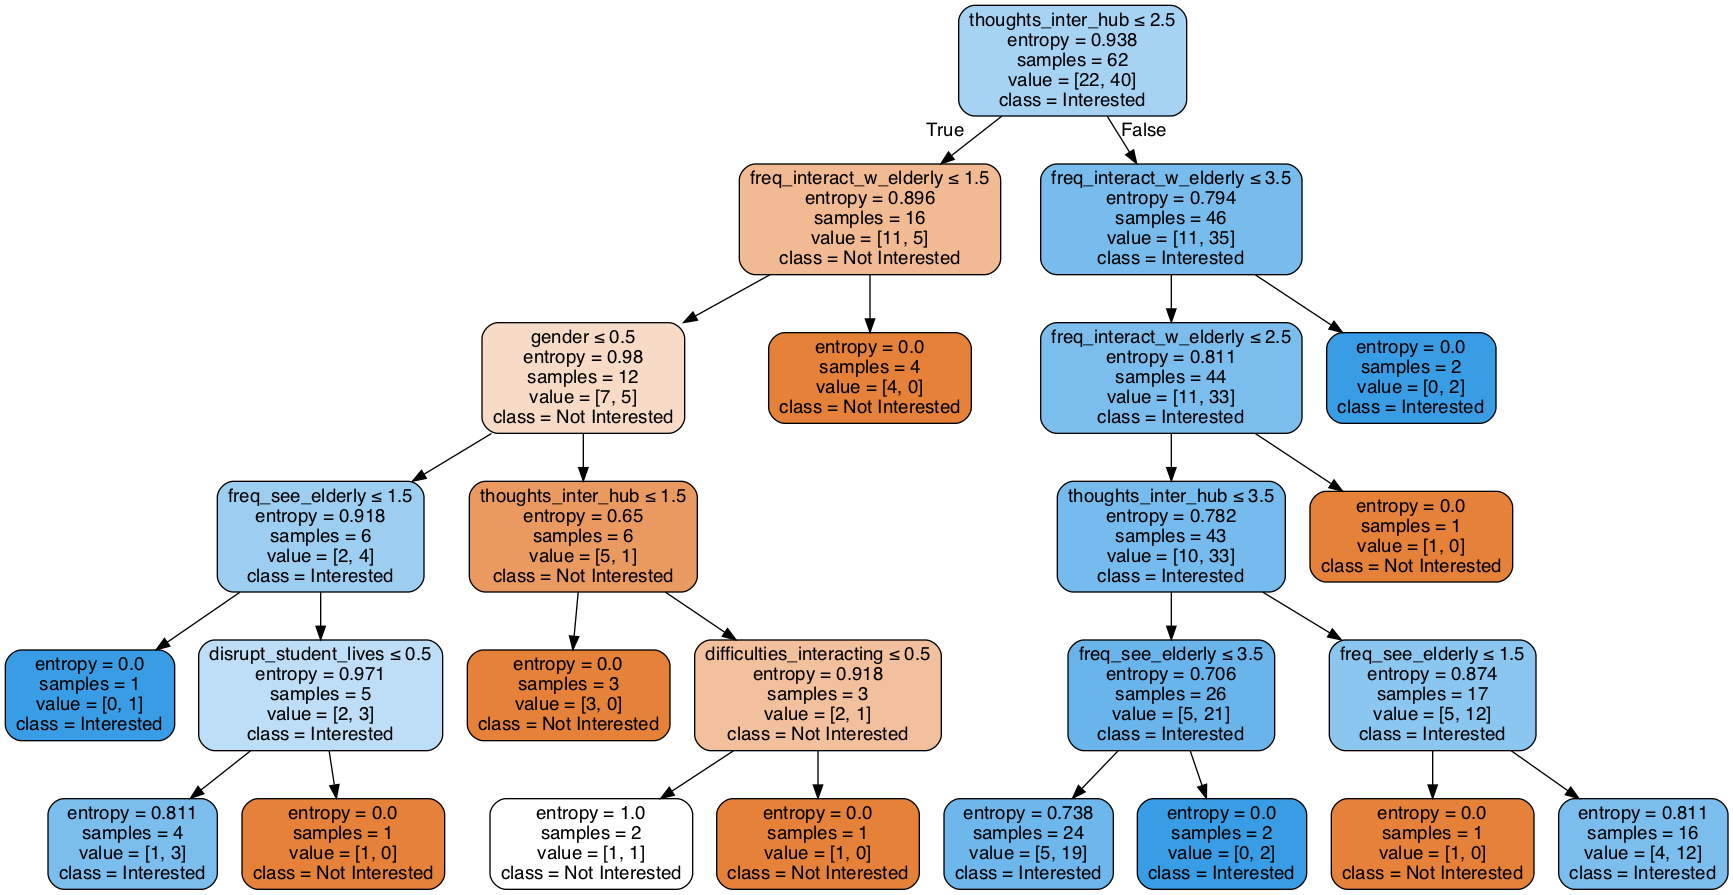

In [23]:
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.externals.six import StringIO  
from IPython.display import Image

feature_cols = x_cols

dot_data = StringIO()
export_graphviz(dt, out_file = dot_data, 
                      feature_names = feature_cols,  
                     filled = True, rounded = True,  
                    special_characters = True,class_names=["Not Interested","Interested"])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('tree_youth.png')
Image(graph.create_png())

In [16]:
from sklearn.ensemble import RandomForestClassifier

max_acc = 0
min_acc = 0.5
max_rfc = None
estimators = 5


## Only uncomment if you have a strong need to retrain the model (Please dont replace the models in backup_best_models)
# for i in range(0,200):
#     rfc = RandomForestClassifier(criterion='entropy',n_estimators=estimators)
#     rfc.fit(X_train,y_train)

#     y_pred = rfc.predict(X_test)
#     acc_score = round(accuracy_score(y_test, y_pred), 3)

#     if(acc_score >= min_acc and acc_score > max_acc):
#         max_acc = acc_score
#         max_rfc = rfc

#         print("Accuracy for Random Forest Tree :")
#         print(acc_score)

        
# joblib.dump(max_rfc,"random_forest_classifier_youth.sav")

max_rfc = joblib.load("./backup_best_models/random_forest_classifier_youth.sav")

In [17]:

for i in range(len(feature_cols)):
    print(feature_cols[i],":",max_rfc.feature_importances_[i])


gender : 0.10630759355315132
freq_see_elderly : 0.20309410156126162
knowledge_elderly_pop : 0.07918856644678446
freq_interact_w_elderly : 0.13782349399623556
difficulties_interacting : 0.0435029792672991
disrupt_student_lives : 0.09795554723295223
thoughts_inter_hub : 0.3321277179423158


In [18]:
# max_acc = 0
# max_tree = None

# best_tree_random_forest = None
# for tree in max_rfc.estimators_:
    
#     dt_score = []

#     for train_index, test_index in loo.split(x_data.to_numpy()):
    
#         X_loo_train, X_loo_test = x_data.to_numpy()[train_index], x_data.to_numpy()[test_index]
#         y_loo_train, y_loo_test = y_data.to_numpy()[train_index], y_data.to_numpy()[test_index]


#         y_predict = tree.predict(X_loo_test)
#         dt_score.append(metrics.accuracy_score(y_loo_test,y_predict))

    
#     print("Avg Cross Validation Score of Current Tree",sum(dt_score)/len(dt_score))
    
    
#     result = tree.predict(X_test)
#     acc_score = round(accuracy_score(y_test, result), 3)
#     print("Accuracy Score:",acc_score)
    
#     if acc_score >= 0.8 and acc_score > max_acc:
#         max_acc = acc_score
#         max_tree = tree

# dot_data = StringIO()
# export_graphviz(max_tree, out_file = dot_data, 
#                       feature_names = feature_cols,  
#                      filled = True, rounded = True,  
#                     special_characters = True,class_names=["Not Interested","Interested"])

# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
# graph.write_png('randomforest_best_tree_youth.png')
        
# joblib.dump(max_tree,"random_forest_best_tree_youth.sav")
# Image(graph.create_png())


In [19]:
#SVM
from sklearn import svm

clf = svm.SVC(kernel='rbf',probability=True)
clf.fit(X_train, y_train)



/Users/eugene/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [20]:
#Cross Validation
loo = LeaveOneOut()

svm_score = []

for train_index, test_index in loo.split(x_data.to_numpy()):
    
    X_loo_train, X_loo_test = x_data.to_numpy()[train_index], x_data.to_numpy()[test_index]
    y_loo_train, y_loo_test = y_data.to_numpy()[train_index], y_data.to_numpy()[test_index]
    
        
    y_predict = clf.predict(X_loo_test)
    svm_score.append(metrics.accuracy_score(y_loo_test,y_predict))

    
print("Avg Cross Validation Score of SVM",sum(svm_score)/len(svm_score))

Avg Cross Validation Score of SVM 0.7567567567567568


In [21]:
result = clf.predict(X_test)
print(result)
acc_score = round(accuracy_score(y_test, result), 3)
print(acc_score)
#joblib.dump(clf,"SVM_youth.sav")

[1 1 1 0 0 1 0 1 1 1 1 1]
0.583
